In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from collections import defaultdict




In [2]:
config_file ="ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt"
frozen_model="frozen_inference_graph.pb"

In [3]:
model= cv2.dnn_DetectionModel(config_file,frozen_model)

In [4]:
classlabels={}
file_name="labels.txt"
with open(file_name,"rt") as fpt:
    classlabels = fpt.read().rstrip("\n").split("\n")

In [5]:
print(classlabels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'SmartPhone', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'rabbit', 'rat', 'bird', 'dog', 'cat', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'SmartPhone']


In [6]:
print(len(classlabels))

82


In [7]:
model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5,127,5,127.5))
model.setInputSwapRB(True)

< cv2.dnn.Model 0000022F70D146F0>

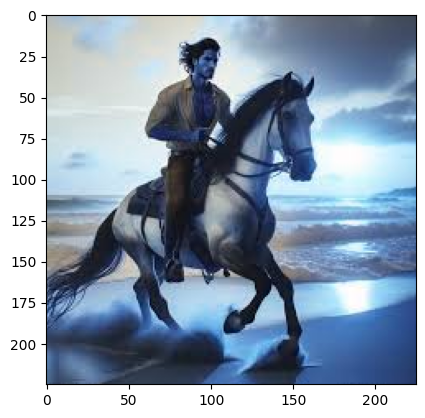

In [8]:
img=cv2.imread("download (3).jpg")

plt.imshow(img)

In [9]:
ClassIndex, confidence ,bbox= model.detect(img,confThreshold=0.5)

In [10]:
print(ClassIndex)

[ 1 19]


In [11]:
font_scale=3
font=cv2.FONT_HERSHEY_PLAIN
for classInd, cof, boxes in zip (ClassIndex.flatten(),confidence.flatten(),bbox):
    cv2.rectangle(img,boxes,(255,0,0),2)
    cv2.putText(img, classlabels[classInd-1], (boxes[0] + 10, boxes[1] +40), font, fontScale=font_scale, color=(0, 255, 0), thickness=3)



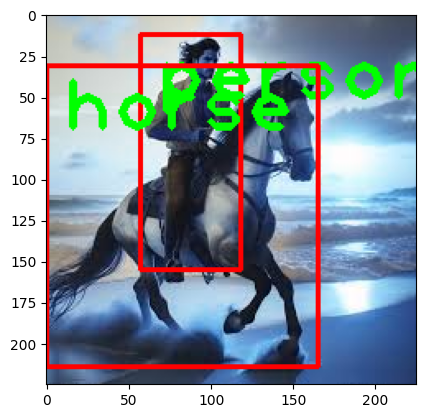

In [12]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2BGRA))

In [13]:

# Video source
#cap = cv2.VideoCapture(1)  # Use camera as video source
cap = cv2.VideoCapture("VID20250103105912.mp4")
# Check if the video source is opened
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Could not open video source")

font_scale = 1
font = cv2.FONT_HERSHEY_SIMPLEX

# Initialize dictionaries for tracking objects
frame_object_ids = set()  # Objects currently in the frame
object_ids = {}  # bounding boxes to unique IDs
next_id = 1  # Unique ID for the next object

# Helper function to check if two bounding boxes overlap
def boxes_overlap(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

# Initialize VideoWriter to save output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Use XVID codec
output_video = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (640, 480))  
with open("count.txt", "w") as count_file:


 while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    ClassIndex, confidence, boxes = model.detect(frame, confThreshold=0.55)

    # Current frame object counts
    current_frame_counts = defaultdict(int)
    current_frame_object_ids = set()

    if len(ClassIndex) != 0:
        for classInd, cof, box in zip(ClassIndex.flatten(), confidence.flatten(), boxes):
            if classInd <= 80:  # Ensure class index is within range
                object_name = classlabels[classInd - 1]  # Get the class label

                # Assign unique IDs to objects in the frame
                matched_id = None
                for obj_id, prev_box in object_ids.items():
                    if boxes_overlap(box, prev_box):
                        matched_id = obj_id
                        break

                if matched_id is None:  # Assign a new ID if no match is found
                    matched_id = next_id
                    next_id += 1

                # Update object tracking
                object_ids[matched_id] = box
                current_frame_object_ids.add(matched_id)

                # Update the count for the current frame
                current_frame_counts[object_name] += 1

                # Draw bounding box and label
                label = f"{object_name}: {int(cof * 100)}%"
                cv2.rectangle(frame, box, (200, 0, 0), 3)
                cv2.putText(frame, label, 
                            (box[0] + 10, box[1] + 30), 
                            font, fontScale=font_scale, 
                            color=(0, 255, 0), thickness=2)

    # Update the set of object IDs currently in the frame
    frame_object_ids = current_frame_object_ids

    # Calculate total objects in the current frame
    total_objects_in_frame = sum(current_frame_counts.values())

    # Save the counts for each object and the total count to the file
    count_file.write(f"Frame {int(cap.get(cv2.CAP_PROP_POS_FRAMES))}: ")
    for obj, count in current_frame_counts.items():
        count_file.write(f"{obj}={count} ")
    count_file.write(f"Total={total_objects_in_frame}\n")

    # Display current frame counts (left side)
    y_offset_left = 80
    x_offset_left = 10
    cv2.putText(frame, "Current Frame Counts:", 
                (x_offset_left, 80), font, fontScale=.7, 
                color=(0, 255, 250), thickness=2)

    for obj, count in current_frame_counts.items():
        cv2.putText(frame, f"{obj}: {count}", 
                    (280,y_offset_left), font, fontScale=.7, 
                    color=(0, 0, 0), thickness=2)
        y_offset_left += 50
  # Display total objects in frame (right side)
    y_offset_right = 50
    x_offset_right = frame.shape[1] - 300
    cv2.putText(frame, "Total Objects in Frame:", 
                (430, 80), font, fontScale=.7, 
                color=(0, 255, 255), thickness=2)

    cv2.putText(frame, f"{total_objects_in_frame}", 
                (450, 120), font, fontScale=.7, 
                color=(0, 0, 0), thickness=2)
    # Display real-time object detection system (center)
    center_x =400 // 2 - 150
    center_y = 30
    cv2.putText(frame, "Real-time Object Detection and Counting System", 
                (center_x, center_y), font, fontScale=.8, 
                color=(0, 0, 255), thickness=2)

    # Write the frame to the output video
    output_video.write(frame)

    # Display the frame in full screen
    cv2.namedWindow("Object Detection and Counting", cv2.WINDOW_NORMAL)
    #cv2.setWindowProperty("Object Detection and Counting", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    # Show the frame
    cv2.imshow("Object Detection and Counting", frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(2) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
output_video.release()
cv2.destroyAllWindows()


